## Automated anisotropic resistivity inversion for efficient formation evaluation and uncertainty quantification

### Misael M. Morales, Michael Pyrcz, Carlos Torres-Verdin, 2024
***

In [1]:
from main import *
ari = ARI()


------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.2.0 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080
------------------------------------------------------------



In [ ]:
case1, case2 = ari.load_data()

case1_qinv = ari.quadratic_inversion(case1)
case2_qinv = ari.quadratic_inversion(case2)

In [ ]:
inv1 = ari.resistivity_inversion(case1)
ari.plot_inversion_results(inv1)

In [ ]:
inv2 = ari.resistivity_inversion(case2)
ari.plot_inversion_results(inv2)

***
# END

In [2]:
import torch
import torch.nn as nn

In [3]:
case1, case2 = ari.load_data()
case1.shape

(2399, 7)

In [4]:
class PINNari(nn.Module):
    def __init__(self):
        super(PINNari, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

In [5]:
class PhysicsLoss(nn.Module):
    def __init__(self, model, Rvsh, Rhsh):
        super(PhysicsLoss, self).__init__()
        self.model = model
        self.Rvsh = Rvsh
        self.Rhsh = Rhsh

    def forward(self, Rv_true, Rh_true):
        Csh, Rs = self.model(torch.tensor([Rv_true, Rh_true], dtype=torch.float32))
        Csh = torch.sigmoid(Csh)
        Rs  = torch.abs(Rs)

        eq1 = Csh*self.Rvsh + (1-Csh)*Rs - Rv_true
        eq2 = Csh/self.Rhsh + (1-Csh)/Rs - 1/Rh_true
        eqs = torch.cat([eq1, eq2])
        Wd  = torch.cat([1/Rv_true, 1/Rh_true])

        loss = torch.norm(Wd*eqs, p=2)**2
        return loss

In [6]:
res_aniso = case1[['Rv','Rh']]
Rvsh, Rhsh = np.percentile(res_aniso['Rv'], 90), np.percentile(res_aniso['Rh'], 90)

model     = PINNari()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = PhysicsLoss(model, Rvsh, Rhsh)

epochs = 20
for _, row in res_aniso.iterrows():
    Rv_true, Rh_true = row['Rv'], row['Rh']
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = criterion(Rv_true, Rh_true)
        loss.backward()
        optimizer.step()

adjoints = {}
for name, param in model.named_parameters():
    if param.grad is not None:
        adjoints[name] = param.grad.clone().detach()

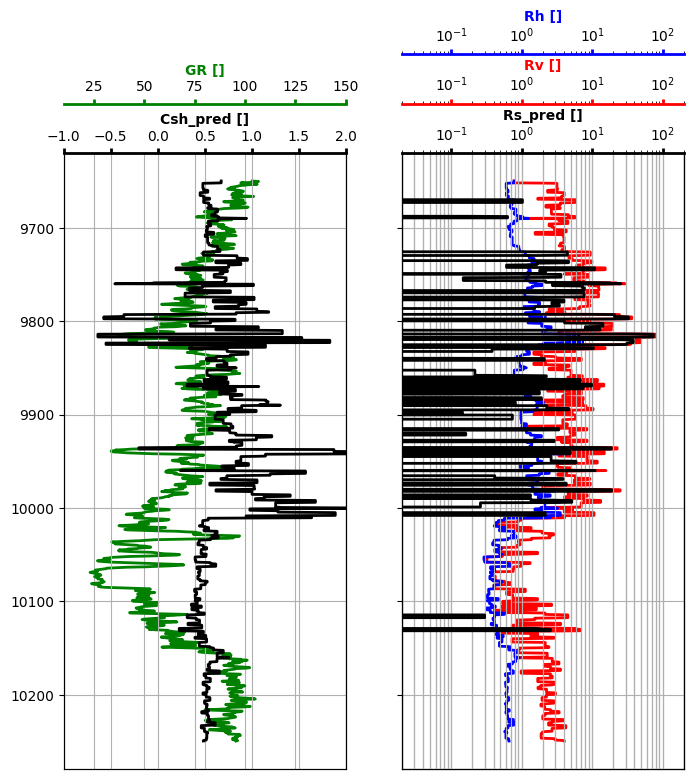

In [26]:
pred = model(torch.tensor(case1[['Rv','Rh']].values, dtype=torch.float32))
csh_pred = pred[:,1].detach().numpy()
rs_pred  = pred[:,0].detach().numpy()
sol = pd.DataFrame({'Csh_pred':csh_pred, 'Rs_pred':rs_pred}, index=case1.index)

fig, axs = plt.subplots(1,2,figsize=(8,8), sharey=True)
ax1, ax2 = axs

ax11 = ax1.twiny()
ari.plot_curve(ax1, case1, 'GR', 10, 150, 'g', pad=8)
ari.plot_curve(ax11, sol, 'Csh_pred', -1, 2, 'k')


ax21, ax22 = ax2.twiny(), ax2.twiny()
ari.plot_curve(ax2, case1, 'Rv', 0.02, 200, 'r', semilog=True, pad=8)
ari.plot_curve(ax21, case1, 'Rh', 0.02, 200, 'b', semilog=True, pad=16)
ari.plot_curve(ax22, sol, 'Rs_pred', 0.02, 200, 'k', semilog=True)

[ax.grid(True, which='both') for ax in axs]
ax1.invert_yaxis()
plt.show()

In [256]:
from torch.utils.data import Dataset, DataLoader

In [283]:
class pinnARI(nn.Module):
    def __init__(self):
        super(pinnARI, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [284]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = torch.tensor(dataframe.values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [333]:
class CustomLoss(nn.Module):
    def __init__(self, Rvsh, Rhsh, lambda_reg=1e-6):
        super(CustomLoss, self).__init__()
        self.Rvsh = Rvsh
        self.Rhsh = Rhsh
        self.lambda_reg = lambda_reg

    def forward(self, outputs, targets):
        Rv_true, Rh_true = targets[:, 0], targets[:, 1]

        Csh_pred = torch.sigmoid(outputs[:, 0])  # Csh in [0, 1]
        Rs_pred  = torch.exp(outputs[:, 1])      # Rs > 0

        Rv_sim = Csh_pred * self.Rvsh + (1 - Csh_pred) * Rs_pred
        Rh_sim = 1 / (Csh_pred / self.Rhsh + (1 - Csh_pred) / Rs_pred)

        v_err = (Rv_sim - Rv_true)**2
        h_err = (Rh_sim - Rh_true)**2
        t_err = torch.cat([v_err, h_err])

        error = torch.mean(t_err) + self.lambda_reg*torch.norm(outputs)
        return error

In [334]:
res_aniso  = case1[['Rv','Rh']]
Rvsh, Rhsh = np.percentile(res_aniso['Rv'], 90), np.percentile(res_aniso['Rh'], 90)

dataset    = CustomDataset(res_aniso)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [335]:
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model     = pinnARI().to(device)
criterion = CustomLoss(Rvsh, Rhsh)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

total_loss = []
num_epochs, monitor = 300, 20
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in dataloader:
        optimizer.zero_grad()
        batch   = batch.to(device)
        outputs = model(batch)
        loss    = criterion(outputs, batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    total_loss.append(epoch_loss)
    if (epoch+1) % monitor == 0:
        print('Epoch [{}/{}] | Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss))

Epoch [20/300] | Loss: 1642.1115
Epoch [40/300] | Loss: 1641.2877
Epoch [60/300] | Loss: 1636.2922
Epoch [80/300] | Loss: 1639.6645
Epoch [100/300] | Loss: 1639.6130
Epoch [120/300] | Loss: 1635.6995
Epoch [140/300] | Loss: 1633.3524
Epoch [160/300] | Loss: 1635.2301
Epoch [180/300] | Loss: 1634.4153
Epoch [200/300] | Loss: 1633.2318
Epoch [220/300] | Loss: 1631.4741
Epoch [240/300] | Loss: 1633.4954
Epoch [260/300] | Loss: 1630.3704
Epoch [280/300] | Loss: 1619.3967
Epoch [300/300] | Loss: 1041.5700


tensor([-1.4976, -0.2849], device='cuda:0', grad_fn=<ViewBackward0>)


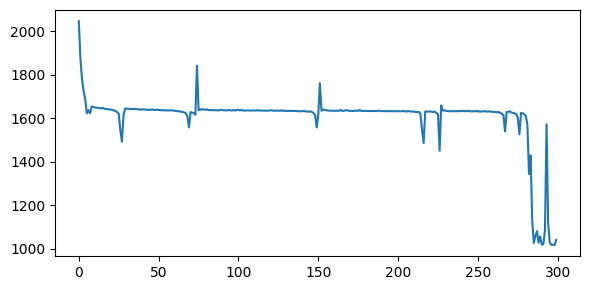

In [345]:
row = 123

u = torch.Tensor(case1[['Rv','Rh']].iloc[row].values).to(device)
print(model(u))

plt.figure(figsize=(6,3))
plt.plot(range(num_epochs), total_loss)
plt.tight_layout(); plt.show()